In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.path import Path

from joblib import Parallel, delayed

In [2]:
from enum import Enum

class PolygonType(Enum):
    CLOSED = 'closed'
    OPEN = 'open'
    TEXTURE = 'textured'
    TEXTURE_WITH_CONTOUR = 'texture with contour'
    DIRECTION = 'directionality'

In [3]:
stack = 'MD594'

first_bs_sec, last_bs_sec = section_range_lookup[stack]

In [5]:
section_contains_label = {}
for sec in range(first_bs_sec, last_bs_sec+1):
    dm = DataManager(stack=stack, section=sec)
    try:
        user, ts, _, res = dm.load_proposal_review_result('yuncong', 'latest', 'consolidated')
        section_contains_label[sec] = set([lm['label'] for lm in res])
    except:
        pass

username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username yuncong does not have any labelings
username y

In [6]:
scoremap = None

In [7]:
def score_transform_affine(tx, ty, theta, scx, scy, a, b, init_cnt):
    
    xmin, ymin = np.min(init_cnt, axis=0)
    xmax, ymax = np.max(init_cnt, axis=0)
    cx, cy = np.mean(init_cnt, axis=0)
    center = np.array([cx, cy])

    xs, ys = np.meshgrid(np.arange(xmin, xmax+1), np.arange(ymin, ymax+1))
    pts = np.c_[xs.flat, ys.flat]
    nzs = pts[np.where(Path(init_cnt).contains_points(pts))[0]]
        
    cos_z = np.cos(theta)
    sin_z = np.sin(theta)
    R = np.array([[scx*cos_z, -scx*sin_z], [scy*sin_z, scy*cos_z]])
    
    test_xs, test_ys = (np.dot(np.dot([[1, a], [b, 1]], R), nzs.T - np.array([cx,cy])[:,np.newaxis]) + \
                        np.array([tx+cx,ty+cy])[:,np.newaxis]).astype(np.int)

    valid = (test_xs >= 0) & (test_ys >= 0) & \
            (test_xs < scoremap.shape[1]) & (test_ys < scoremap.shape[0])
    
    score = scoremap[test_ys[valid], test_xs[valid]].sum() * scx * scy

    return score

In [8]:
def grid_search_affine(init_cnt, init_params=(0, 0, 0, 1., 1., 0, 0), iter_num=10, 
                       sigma_tx0=300, sigma_ty0=300, sigma_theta_z0=0, 
                                        sigma_scx0=0, sigma_scy0=0,
                                        sigma_a0=0, sigma_b0=0):
    
    params_best_upToNow = init_params
    score_best_upToNow = 0

    for iteration in range(iter_num):

#         print iteration

        init_tx, init_ty, init_theta_z, init_scalex, init_scaley, init_a, init_b = params_best_upToNow

        n = int(1000*np.exp(-iteration/10.))
        if n < 10:
            break

        sigma_tx = sigma_tx0*np.exp(-iteration/3.)
        sigma_ty = sigma_ty0*np.exp(-iteration/3.)
        sigma_theta_z = np.deg2rad(sigma_theta_z0*np.exp(-iteration/.6))
        sigma_scx = sigma_scx0*np.exp(-iteration/20.)
        sigma_scy = sigma_scy0*np.exp(-iteration/20.)
        sigma_a = sigma_a0*np.exp(-iteration/5.)
        sigma_b = sigma_b0*np.exp(-iteration/5.)

#         print sigma_tx, sigma_ty, sigma_theta_z, sigma_scx, sigma_scy
            
        tx_grid = init_tx + 2*sigma_tx*np.random.random(n) - sigma_tx
        ty_grid = init_ty + 2*sigma_ty*np.random.random(n) - sigma_ty
        theta_z_grid = init_theta_z + 2*sigma_theta_z*np.random.random(n) - sigma_theta_z
        scalex_grid = init_scalex * np.exp(2*sigma_scx*np.random.random(n) - sigma_scx)
        scaley_grid = init_scaley * np.exp(2*sigma_scy*np.random.random(n) - sigma_scy)
        a_grid = init_a + 2*sigma_a*np.random.random(n) - sigma_a
        b_grid = init_b + 2*sigma_b*np.random.random(n) - sigma_b
        

        scores = Parallel(n_jobs=16)(delayed(score_transform_affine)(tx, ty, theta_z, scx, scy, a, b, init_cnt) 
                                     for tx, ty, theta_z, scx, scy, a, b in zip(tx_grid, ty_grid, theta_z_grid,
                                                               scalex_grid, scaley_grid, a_grid, b_grid))

#         scores = [score_transform_affine(tx, ty, theta_z, scx, scy, a, b, init_cnt) 
#                                      for tx, ty, theta_z, scx, scy, a, b in zip(tx_grid, ty_grid, theta_z_grid,
#                                                                scalex_grid, scaley_grid, a_grid, b_grid)]
        
        
        score_best = np.max(scores)

        tx_best, ty_best, theta_z_best, scalex_best, scaley_best, a_best, b_best = \
            zip(tx_grid, ty_grid, theta_z_grid, scalex_grid, scaley_grid, a_grid, b_grid)[np.argmax(scores)]
            
        
        scalex_best = min(2., max(scalex_best, 0.1))
        scaley_best = min(2., max(scaley_best, 0.1))
            
            
        if score_best > score_best_upToNow:
#             print score_best_upToNow, score_best

            score_best_upToNow = score_best
            params_best_upToNow = tx_best, ty_best, theta_z_best, scalex_best, scaley_best, a_best, b_best

#             print tx_best, ty_best, np.rad2deg(theta_z_best), scalex_best, scaley_best, a_best, b_best
            
    return params_best_upToNow

In [159]:
def optimal_params_slice_affine(init_cnt, scoremap, init_params=(0,0,0,1,1,0,0), 
                                iter_num=100, return_scores=False, lr=(.1,0,1e-6,0)):
    
    
    fudge_factor = 1e-6 #for numerical stability

    dMdu_historical = 0
    dMdv_historical = 0
    dMdaz_historical = 0
    dMdsx_historical = 0
    dMdsy_historical = 0
    
    lr1, lr2, lr3, lr4 = lr
    
    score_best = 0
    
    xmin, ymin = np.min(init_cnt, axis=0)
    xmax, ymax = np.max(init_cnt, axis=0)
    cx, cy = np.mean(init_cnt, axis=0)
    
    xs, ys = np.meshgrid(np.arange(xmin, xmax+1), np.arange(ymin, ymax+1))
    pts = np.c_[xs.flat, ys.flat]
    nzs = pts[np.where(Path(init_cnt).contains_points(pts))[0]].T

    dSdxyz = np.gradient(scoremap, 3, 3)

    scores = []
    hit_sum = []
    valid_num = []

    tx_best, ty_best, theta_best, sx_best, sy_best, a_best, b_best  = init_params

    for iteration in range(iter_num):

        dMdu = 0
        dMdv = 0
        dMdaz = 0
        dMdsx = 0
        dMdsy = 0
        dMda = 0
        dMdb = 0

        cos_z = np.cos(theta_best)
        sin_z = np.sin(theta_best)
        Rz_best = np.array([[sx_best*cos_z, -sx_best*sin_z], 
                            [sy_best*sin_z, sy_best*cos_z]])
        
        t = np.array([tx_best, ty_best])
        center = np.array([cx, cy])
        ds = nzs - center[:, np.newaxis]
                
        xs_prime, ys_prime = (np.dot([[1, a_best],[b_best, 1]], np.dot(Rz_best, ds)) + (t + center)[:,np.newaxis]).astype(np.int)

#         print xs_prime, ys_prime, scoremap.shape
        
        valid = (xs_prime >= 0) & (ys_prime >= 0) & \
                (xs_prime < scoremap.shape[1]) & (ys_prime < scoremap.shape[0])

        if np.count_nonzero(valid) > 0:

            xs_prime_valid = xs_prime[valid]
            ys_prime_valid = ys_prime[valid]
            
            dxs, dys = ds
            dxs_valid = dxs[valid]
            dys_valid = dys[valid]

            xs, ys = nzs
            xs_valid = xs[valid]
            ys_valid = ys[valid]

            Sx = dSdxyz[1][ys_prime_valid, xs_prime_valid]
            Sy = dSdxyz[0][ys_prime_valid, xs_prime_valid]
            S = scoremap[ys_prime_valid, xs_prime_valid].sum()
            
            dMdu += Sx.sum() * (1 + sx_best * sy_best)
            dMdv += Sy.sum() * (1 + sx_best * sy_best)
            
            dx2dsx = dxs_valid*cos_z - dys_valid*sin_z
            dx2dsy = dxs_valid*a_best*sin_z + dys_valid*a_best*cos_z
            
            dy2dsx = dxs_valid*b_best*cos_z + dys_valid*(-b_best*sin_z)
            dy2dsy = dxs_valid*sin_z + dys_valid*cos_z
            
            dMdsx += (np.dot(Sx, dx2dsx) + np.dot(Sy, dy2dsx)) * (1+sx_best*sy_best) + .999*S * sy_best
            dMdsy += (np.dot(Sx, dx2dsy) + np.dot(Sy, dy2dsy)) * (1+sx_best*sy_best) + .999*S * sx_best
            

#             dx2dtheta = dxs_valid*(-sx_best*sin_z+a_best*sy_best*cos_z) + \
#                         dys_valid*(-sx_best*cos_z-a_best*sy_best*sin_z)
        
#             dy2dtheta = dxs_valid*(-b_best*sin_z*sx_best+sy_best*cos_z) + \
#                         dys_valid*(-b_best*sx_best*cos_z-sy_best*sin_z)

#             dMdaz += (np.dot(Sx, dx2dtheta) + np.dot(Sy, dy2dtheta)) * (1 + sy_best * sx_best)

#         print '(dMdu, dMdv):', dMdu, dMdv
#         print '(dMdaz):', dMdaz
#         print '(dMdsx, dMdsy):', dMdsx, dMdsy
#         print '(dMda, dMdb):', dMda, dMdb

#         print 'lr1:', lr1, ', lr2:', lr2, ', lr3:', lr3, ', lr4:', lr4

            dMdu_historical += dMdu**2
            dMdv_historical += dMdv**2
            dMdaz_historical += dMdaz**2
            dMdsx_historical += dMdsx**2
            dMdsy_historical += dMdsy**2

            dMdu_adjusted = dMdu / (fudge_factor + np.sqrt(dMdu_historical))
            dMdv_adjusted = dMdv / (fudge_factor + np.sqrt(dMdv_historical))
            dMdaz_adjusted = dMdaz / (fudge_factor + np.sqrt(dMdaz_historical))
            dMdsx_adjusted = dMdsx / (fudge_factor + np.sqrt(dMdsx_historical))
            dMdsy_adjusted = dMdsy / (fudge_factor + np.sqrt(dMdsy_historical))
        
            tx_best += lr1*dMdu_adjusted
            ty_best += lr1*dMdv_adjusted
            theta_best += lr2*dMdaz_adjusted

            theta_best = theta_best%(2*np.pi)
            if theta_best > np.pi:
                theta_best -= 2*np.pi
            elif theta_best < -np.pi:
                theta_best += 2*np.pi

            sx_best += lr3*dMdsx_adjusted
            sy_best += lr3*dMdsy_adjusted

            sx_best = min(3., max(sx_best, 0.1))
            sy_best = min(3., max(sy_best, 0.1))

            a_best += lr4*dMda
            b_best += lr4*dMdb

    #         print '(tx_best, ty_best):', tx_best, ty_best
    #         print '(theta_best):', theta_best
    #         print '(theta_best) in degrees:', np.rad2deg(theta_best)
    #         print '(scx_best, scy_best):', sx_best, sy_best
    #         print '(a, b):', a_best, b_best

            s = scoremap[ys_prime_valid, xs_prime_valid].sum() * (1 + sx_best * sy_best)
    #         s = scoremap[ys_prime_valid, xs_prime_valid].sum()        
    
            scores.append(s)
            hit_sum.append(scoremap[ys_prime_valid, xs_prime_valid].sum())
            valid_num.append(scoremap[ys_prime_valid, xs_prime_valid].sum() * (sx_best * sy_best))
        
        else:
            scores.append(scores[-1])
            hit_sum.append(hit_sum[-1])
            valid_num.append(valid_num[-1])

    #         print '\n'

#         params_best_upToNow = (tx_best, ty_best, theta_best, sx_best, sy_best, a_best, b_best)

#         print iteration, s, score_best

        if s > score_best:
#             print 'Current best'
            params_best_upToNow = (tx_best, ty_best, theta_best, sx_best, sy_best, a_best, b_best)
            score_best = s
#             print iteration
        
    best_finetune_params = params_best_upToNow
    
    if return_scores:
        return best_finetune_params, scores, hit_sum, valid_num
    else:
        return best_finetune_params

In [10]:
labels_to_detect = ['5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL']

In [11]:
import cPickle as pickle
import datetime

In [25]:
autoAnnotations_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_autoAnnotations'

autoAnnotations_dir = os.path.join(autoAnnotations_rootdir, stack)
if not os.path.exists(autoAnnotations_dir):
    os.makedirs(autoAnnotations_dir)
    
scoremaps_rootdir = '/oasis/projects/nsf/csd395/yuncong/CSHL_scoremaps_lossless'
scoremaps_dir = os.path.join(scoremaps_rootdir, stack)
if not os.path.exists(scoremaps_dir):
    os.makedirs(scoremaps_dir)

In [163]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'

In [164]:
test_volume_atlas_projected = bp.unpack_ndarray_file(volume_dir + '/%(stack)s_volume_atlasProjected.bp'%{'stack':stack})

In [166]:
test_volume_atlas_projected.shape

(375, 690, 419)

In [167]:
from skimage.measure import find_contours

def find_contour_points(labelmap):
    '''
    return is (x,y)
    '''

    regions = regionprops(labelmap)

    contour_points = {}

    for r in regions:

        (min_row, min_col, max_row, max_col) = r.bbox

        padded = np.pad(r.filled_image, ((5,5),(5,5)), mode='constant', constant_values=0)

        contours = find_contours(padded, .5, fully_connected='high')
        contours = [cnt.astype(np.int) for cnt in contours if len(cnt) > 10]
        if len(contours) > 1:
            sys.stderr.write('region has more than one part\n')
        elif len(contours) == 0:
            sys.stderr.write('no contour is found\n')

        pts = contours[0] - (5,5)

        pts_sampled = pts[np.arange(0, pts.shape[0], 10)]

    #         viz = np.zeros_like(r.filled_image)
    #         viz[pts_sampled[:,0], pts_sampled[:,1]] = 1
    #         plt.imshow(viz, cmap=plt.cm.gray);
    #         plt.show();

        contour_points[r.label] = pts_sampled[:, ::-1] + (min_col, min_row)
        
    return contour_points

In [168]:
test_volume_atlas_projected.shape

(375, 690, 419)

In [ ]:
downsample_factor = 16

section_thickness = 20 # in um
xy_pixel_distance_lossless = 0.46
xy_pixel_distance_tb = xy_pixel_distance_lossless * 32 # in um, thumbnail
# factor = section_thickness/xy_pixel_distance_lossless

xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
z_xy_ratio_downsampled = section_thickness / xy_pixel_distance_downsampled

stack = 'MD594'
    
# build annotation volume
section_bs_begin, section_bs_end = section_range_lookup[stack]
print section_bs_begin, section_bs_end

first_bs_sec, last_bs_sec = (150, 303)

if stack == 'MD594':
#     roi_zmin, roi_zmax = (815, 1651)

    

    roi_zmin, roi_zmax = (815/2, 1651/2)

map_z_to_section = {}
for s in range(first_bs_sec, last_bs_sec+1):
    for z in range(int(z_xy_ratio_downsampled*s) - roi_zmin, int(z_xy_ratio_downsampled*(s+1)) - roi_zmin + 1):
        map_z_to_section[z] = s

In [ ]:
z = 40
find_contour_points(test_volume_atlas_projected[..., z])

In [ ]:
viz1 = dm.image_rgb_jpg[::8, ::8][volume_ymin:volume_ymax+1, volume_xmin:volume_xmax+1][::2, ::2]


No neighbor within three sections has annotation of class 5N.
No neighbor within three sections has annotation of class 12N.
No neighbor within three sections has annotation of class Gr.
No neighbor within three sections has annotation of class LVe.
No neighbor within three sections has annotation of class SuVe.


179
(0.0, 0.0, 0.0, 1.8111481707862738, 1.8371429949217226, 0, 0)


No neighbor within three sections has annotation of class VLL.


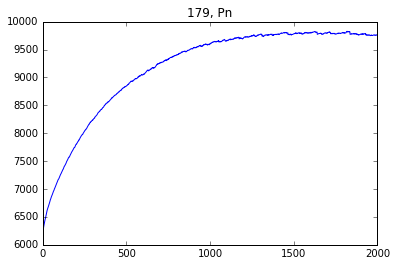

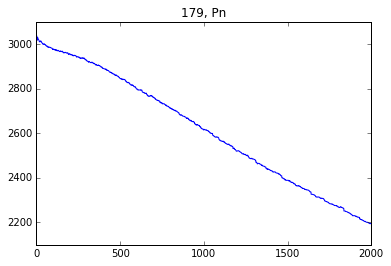

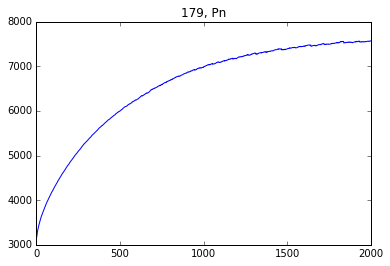

In [160]:
# for sec in range(first_bs_sec, last_bs_sec+1):
for sec in [179]:
    
    print sec
    
    
    #########################
    
    ref_sections = {}
    init_annotations = {}

    for l in labels_to_detect:

        nbrs_containing_this_label = [(abs(nbr-sec), nbr) for i, nbr in enumerate(range(sec-3,sec)+range(sec+1,sec+4)) 
                if nbr in section_contains_label and l in section_contains_label[nbr]]

        if len(nbrs_containing_this_label) == 0:
            sys.stderr.write('No neighbor within three sections has annotation of class %s.\n' % l)
            continue

        closest_nbr = sorted(nbrs_containing_this_label)[0][1]

        dm = DataManager(stack=stack, section=closest_nbr)
        user, ts, _, res = dm.load_proposal_review_result('yuncong', 'latest', 'consolidated')

        lms = [lm for lm in res if lm['label'] == l]
        if len(lms) > 1:
            sys.stderr.write('Region %s has more than one part.' % l)
        else:
            assert len(lms) == 1

        init_annotations[l] = lms[0]
            
        ref_sections[l] = closest_nbr

    #########################
        
    new_res = []

#     for l in set(labels_to_detect) & set(init_annotations.keys()):
    for l in ['Pn']:
        
        lm = init_annotations[l]
        
        init_cnt = lm['vertices']
        init_cnt = (init_cnt/8).astype(np.int)
        
#         cx, cy = np.mean(init_cnt, axis=0)
#         center = np.array([cx, cy])
#         init_cnt =  .5*(init_cnt - center) + center

        global scoremap
        scoremap = bp.unpack_ndarray_file(os.path.join(scoremaps_dir, 
                   '%(sec)04d/%(stack)s_%(sec)04d_roi1_denseScoreMapLossless_%(label)s.bp' % \
                                                       {'stack': stack, 'sec': sec, 'label': l}))

        scoremap = scoremap[::8, ::8]


#         params = grid_search_affine(init_cnt,iter_num=10, init_params=(0, 0, 0, 1., 1, 0, 0), 
#                                    sigma_tx0=300, sigma_ty0=300, sigma_theta_z0=0, 
#                                             sigma_scx0=0, sigma_scy0=0,
#                                             sigma_a0=0, sigma_b0=0)

        
        best_finetune_params, scores, hit_sum, valid_num = optimal_params_slice_affine(init_cnt, scoremap, 
                                                                                       init_params=(0, 0, 0, 1., 1, 0, 0),
                                                      iter_num=2000, return_scores=True, lr=(0,0,1e-2,0))
        
        print best_finetune_params
        
#         best_finetune_params, scores = optimal_params_slice_affine(init_cnt, scoremap, init_params=params,
#                                                           iter_num=1000, return_scores=True, lr=(1e-2,1e-6,1e-6,0))

        
        plt.figure();
        plt.plot(scores);
        plt.title('%d, %s'%(sec, l));
        plt.show();

        plt.figure();
        plt.plot(hit_sum);
        plt.title('%d, %s'%(sec, l));
        plt.show();
        
        plt.figure();
        plt.plot(valid_num);
        plt.title('%d, %s'%(sec, l));
        plt.show();
        
        tx_best, ty_best, theta_best, sx_best, sy_best, a_best, b_best = best_finetune_params


        xmin, ymin = np.min(init_cnt, axis=0)
        xmax, ymax = np.max(init_cnt, axis=0)
        cx, cy = np.mean(init_cnt, axis=0)
        center = np.array([cx, cy])

        cos_z = np.cos(theta_best)
        sin_z = np.sin(theta_best)
        R = np.array([[sx_best*cos_z, -sx_best*sin_z], 
                      [sy_best*sin_z, sy_best*cos_z]])

        t = np.array([tx_best, ty_best])

        xs, ys = (np.dot(np.dot([[1, a_best], [b_best, 1]], R), 
                         init_cnt.T - center[:, np.newaxis]) + (t+center)[:, np.newaxis]).astype(np.int)

        valid = (xs >= 0) & (ys >= 0) & (xs < scoremap.shape[1]) & (ys < scoremap.shape[0])

        new_cnt = np.c_[xs, ys][valid]


        new_lm = lm.copy()
        new_lm['vertices'] = new_cnt * 8
        new_lm['labelPos'] = np.array(lm['labelPos']) + (tx_best*8, ty_best*8)

        new_lm['refVertices'] = lm['vertices']
        new_lm['refSection'] = ref_sections[l]

        new_res.append(new_lm)

    ##########################################

    
#     timestamp = datetime.datetime.now().strftime("%m%d%Y%H%M%S")

#     autoAnnotation_filepath = autoAnnotations_dir + '/%(stack)s_%(sec)04d_autoAnnotate_%(timestamp)s_consolidated.pkl' % \
#                         {'stack': stack, 'sec': sec, 'timestamp': timestamp}

#     pickle.dump(new_res, open(autoAnnotation_filepath, 'w'))
    
    
    ##########################################

    # viz1 = cropped_img
    # viz2 = plt.cm.hot(scoremap)
    # viz = img_as_ubyte(alpha_blending(viz1, viz2[...,:3], .9, 1.))


#     dm = DataManager(stack=stack, section=sec)
#     dm._load_image(versions=['rgb-jpg'])
#     cropped_img = dm.image_rgb_jpg[::8, ::8][567:1316+1, 399:1778+1]

#     viz = cropped_img.copy()

#     for lm in new_res:

#     # for pt in init_cnt:
#     #     cv2.circle(viz, tuple(pt), 2, (0,255,0,255), -1)

#         ref_cnt = np.array(lm['refVertices']).astype(np.int)/8-(399,567)
#         for xy in ref_cnt:
#             cv2.circle(viz, tuple(xy), 3, (0,255,0), -1)

#         new_cnt = np.array(lm['vertices'])/8-(399,567)
#         for xy in new_cnt:
#             cv2.circle(viz, tuple(xy), 5, (255,0,0), -1)
#         cv2.polylines(viz, [new_cnt.astype(np.int)], True, (255,0,0), 2)


#         if sec in section_contains_label and lm['label'] in section_contains_label[sec]:
#             dm = DataManager(stack=stack, section=sec)
#             user, ts, _, res = dm.load_proposal_review_result('yuncong', 'latest', 'consolidated')
#             manual_cnt = [x['vertices'] for x in res if x['label'] == lm['label']][0]
#             manual_cnt = np.array(manual_cnt)/8-(399,567)

#             for xy in manual_cnt.astype(np.int):
#                 cv2.circle(viz, tuple(xy), 3, (0,0,255), -1)
#             cv2.polylines(viz, [manual_cnt.astype(np.int)], True, (0,0,255), 2)


#         lx, ly = lm['labelPos']/8 - (399, 567)
#         cv2.putText(viz, lm['label'], (int(lx)-10, int(ly)+10), cv2.FONT_HERSHEY_DUPLEX, 1, ((0,0,0)), 3)

#     cv2.imwrite(autoAnnotation_dir + '/%(stack)s_%(sec)04d_autoAnnotationViz.jpg' % \
#                 {'stack': stack, 'sec': sec}, viz[..., ::-1])

In [161]:
dm = DataManager(stack=stack, section=sec)
dm._load_image(versions=['rgb-jpg'])
cropped_img = dm.image_rgb_jpg[::8, ::8]
viz = cropped_img.copy()

for lm in new_res:

# for pt in init_cnt:
#     cv2.circle(viz, tuple(pt), 2, (0,255,0,255), -1)

    ref_cnt = np.array(lm['refVertices']).astype(np.int)/8
    for xy in ref_cnt:
        cv2.circle(viz, tuple(xy), 3, (0,255,0), -1)

    new_cnt = np.array(lm['vertices'])/8
    for xy in new_cnt:
        cv2.circle(viz, tuple(xy), 5, (255,0,0), -1)
    cv2.polylines(viz, [new_cnt.astype(np.int)], True, (255,0,0), 2)


    if sec in section_contains_label and lm['label'] in section_contains_label[sec]:
        dm = DataManager(stack=stack, section=sec)
        user, ts, _, res = dm.load_proposal_review_result('yuncong', 'latest', 'consolidated')
        manual_cnt = [x['vertices'] for x in res if x['label'] == lm['label']][0]
        manual_cnt = np.array(manual_cnt)/8

        for xy in manual_cnt.astype(np.int):
            cv2.circle(viz, tuple(xy), 3, (0,0,255), -1)
        cv2.polylines(viz, [manual_cnt.astype(np.int)], True, (0,0,255), 2)


    lx, ly = lm['labelPos']/8
    cv2.putText(viz, lm['label'], (int(lx)-10, int(ly)+10), cv2.FONT_HERSHEY_DUPLEX, 1, ((0,0,0)), 3)

# cv2.imwrite(autoAnnotation_dir + '/%(stack)s_%(sec)04d_autoAnnotationViz.jpg' % \
#             {'stack': stack, 'sec': sec}, viz[..., ::-1])

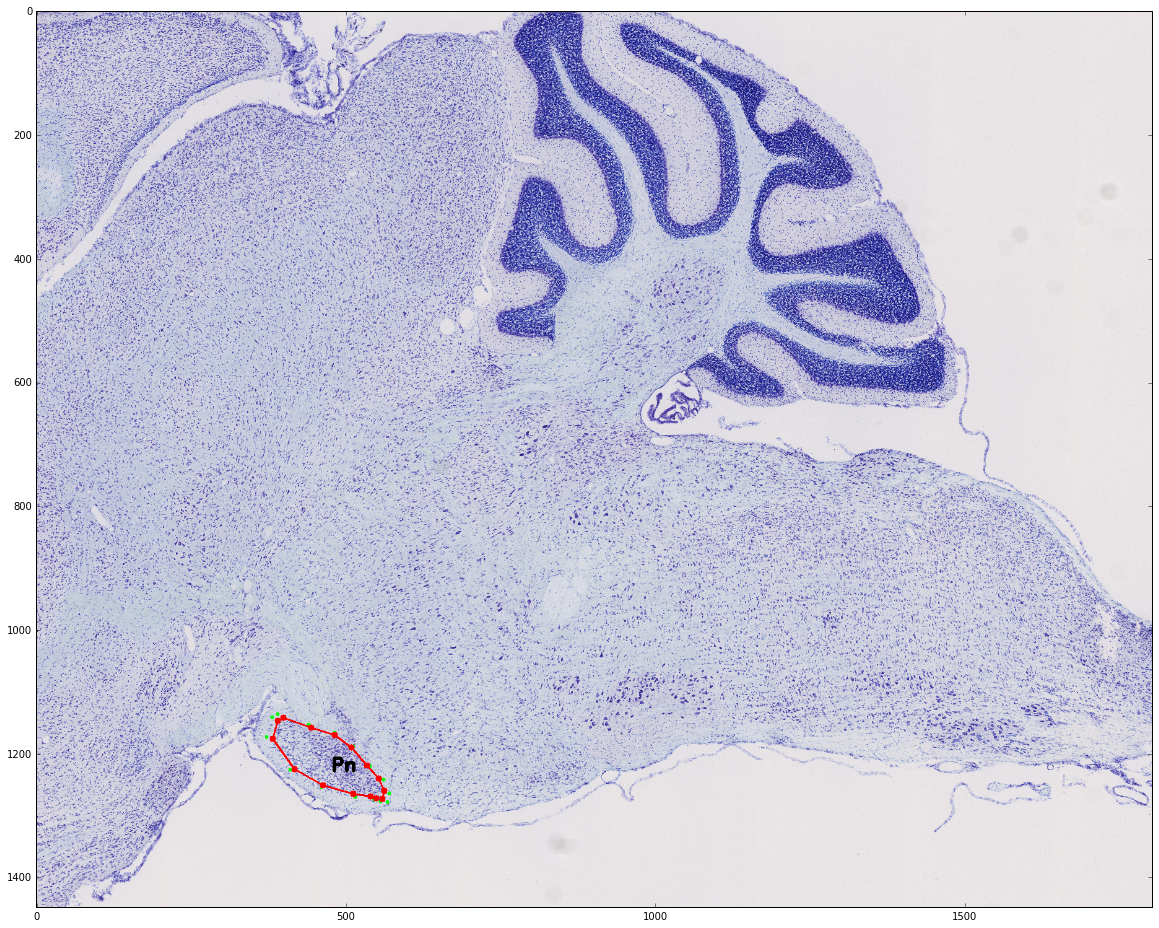

In [162]:
plt.figure(figsize=(20,20));
plt.imshow(viz);

In [90]:
display(viz)

/oasis/projects/nsf/csd395/yuncong/Brain/cross-brain/tmp.jpg